In [1]:
# https://datahacker.rs/006-gans-how-to-develop-a-1d-gan-from-scratch/

In [2]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import torch.nn.functional as F

In [4]:
def sine_function(x):
    return torch.sin(x)

# test sine_function()    
print(sine_function(torch.tensor(torch.pi * 0.5 )))
print(sine_function(torch.tensor(torch.pi * 0. )))

tensor(1.)
tensor(0.)


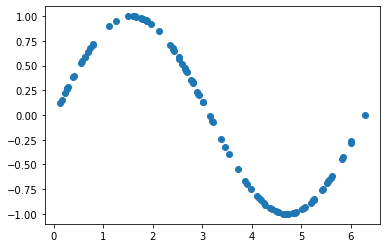

In [5]:
x = torch.rand(100) * 2 * torch.pi
y = sine_function(x)
# plot the sine wave function
plt.scatter(x.numpy(), y.numpy())

In [6]:
def generate_data_samples(n=100):
    # here we define the number of n numbers from a Uniform distribution
    x1 = torch.rand(n) * 2 * torch.pi
    x2 = sine_function(x1)
    x1 = x1.view(n,1)
    x2 = x2.view(n,1)
    y_data = torch.ones((n,1))

    return torch.hstack((x1, x2)), y_data

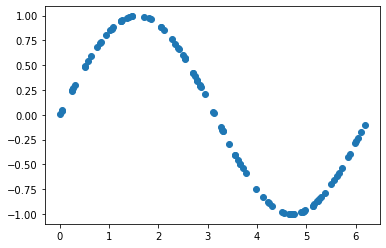

In [7]:
test_generated_data = generate_data_samples(100)

plt.scatter(test_generated_data[0][:,0].numpy(), test_generated_data[0][:,1].numpy())

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(2, 25)
        self.fc2 = nn.Linear(25,1)

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [9]:
discriminator = Discriminator()
# test a discriminator with a simple input - sanity check
x_data_test = torch.rand(2)
discriminator(x_data_test)

tensor([0.3892], grad_fn=<SigmoidBackward0>)

In [10]:
def generate_dummy_fake_data(n):
    x1 = torch.rand(n) * 2 * torch.pi
    x2 = torch.rand(n) * 2 * torch.pi
    x1 = x1.view(n,1)
    x2 = x2.view(n,1)
    y_fake = torch.zeros((n,1))
    return torch.hstack((x1, x2)), y_fake

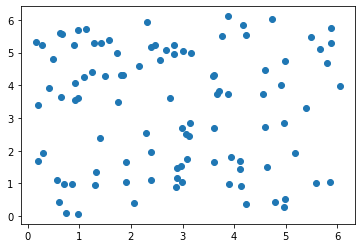

In [11]:
x_fake,y_fake = generate_dummy_fake_data(100)
plt.scatter(x_fake[:, 0].numpy(),x_fake[:, 1].numpy())

In [12]:
discriminator = Discriminator()
optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.001) 
criterion = torch.nn.BCELoss()

In [13]:
epochs = 1000
n = 100
x_data, y_data = generate_data_samples(n)
x_fake, y_fake = generate_dummy_fake_data(n)

x_all = torch.vstack((x_data, x_fake))
y_all = torch.vstack((y_data, y_fake))
all_loss = []
for i in range(epochs):
    y_hat = discriminator(x_all)
    loss = criterion(y_hat, y_all)
    all_loss.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

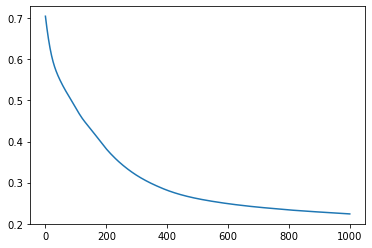

In [14]:
plt.plot(all_loss)

In [15]:
# define a Generator Model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(5,15)
        self.fc2 = nn.Linear(15, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # note that here we are not adding any activation functions
        # since we assume the linear output as the values can be negative as well
        # in other words this activation function here is just an "identity function" f(x)=x
        return x

In [16]:
generator = Generator()
test_generator = generator(torch.rand(5))
print(test_generator)

tensor([0.3233, 0.0193], grad_fn=<ViewBackward0>)


In [17]:
def generate_latent_points(n, latent_dim=5):
    # here we will assume that in the z-space 
    # or latent space we have 5 dimensional random vector 
    z = torch.rand(n*latent_dim)
    return z.view((n,latent_dim))

a = generate_latent_points(10)
print(a)

tensor([[0.1295, 0.1874, 0.9095, 0.3010, 0.0834],
        [0.8754, 0.9548, 0.0648, 0.9894, 0.0615],
        [0.5957, 0.8327, 0.7351, 0.6258, 0.3027],
        [0.3193, 0.1908, 0.2449, 0.1315, 0.3424],
        [0.4276, 0.5622, 0.4182, 0.7386, 0.9760],
        [0.2043, 0.9000, 0.8908, 0.0958, 0.2605],
        [0.9206, 0.6785, 0.4909, 0.7992, 0.0294],
        [0.8462, 0.1097, 0.3580, 0.6223, 0.7642],
        [0.5535, 0.4141, 0.6943, 0.4394, 0.8999],
        [0.9144, 0.9927, 0.4250, 0.1243, 0.4524]])


In [18]:
def generate_fake_samples(generator, n, latent_dim=5):
    z = generate_latent_points(n)
    fake_data = generator(z)
    return fake_data 

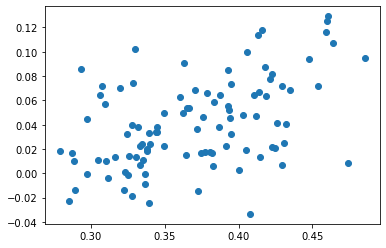

In [19]:
fake_data_test = generate_fake_samples(generator, 100)
plt.scatter(fake_data_test[:,0].detach().numpy(), fake_data_test[:,1].detach().numpy())

In [20]:
training_steps = 200000    

# Models
generator =     Generator()
discriminator = Discriminator()

# Optimizers
generator_optimizer     = torch.optim.Adam(generator.parameters(),     lr=0.001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# loss
loss = nn.BCELoss()

N = 128

for i in tqdm(range(training_steps)):
    # zero the gradients on each iteration
    generator_optimizer.zero_grad()
#    if i%5000 ==0:
#        print(f"{i} \n")

    # Create a fake data with a generator
    fake_data = generate_fake_samples(generator, N)

    # here we define the INVERSE labels for fake data
    fake_data_label = torch.ones(N,1)

    # Generate examples of real data
    real_data, real_data_label = generate_data_samples(N)
    
    # Train the generator
    # We invert the labels here and don't train the discriminator because we want the generator
    # to make things the discriminator classifies as true.
    generator_discriminator_out = discriminator(fake_data)
    generator_loss = loss(generator_discriminator_out, fake_data_label)
    generator_loss.backward()
    generator_optimizer.step()

    # Train the discriminator on the true/generated data
    discriminator_optimizer.zero_grad()
    true_discriminator_out = discriminator(real_data)
    true_discriminator_loss = loss(true_discriminator_out, real_data_label)

    # here a fake_data is passed with a gradient turned off
    # see our post about <a href="https://datahacker.rs/004-computational-graph-and-autograd-with-pytorch/#Automatic-differentiation-module-in-PyTorch---Autograd">AUTOGRAD</a>
    generator_discriminator_out = discriminator(fake_data.detach())
    generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(N,1))
    discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
    discriminator_loss.backward()
    discriminator_optimizer.step()

100%|██████████████████████████████████| 200000/200000 [04:54<00:00, 680.26it/s]


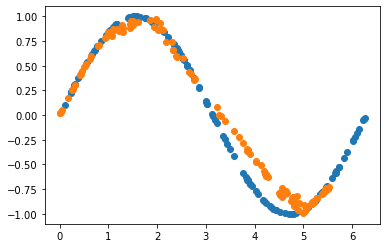

In [21]:
plt.scatter(real_data[:,0].detach().numpy(), real_data[:,1].detach().numpy())
plt.scatter(fake_data[:,0].detach().numpy(), fake_data[:,1].detach().numpy())